Current record. 

train = 0.9485466597386601

test = 0.9123056381207566

num_features = 52

number of engineered features: 1 {'year_old_square': np.sqrt(2010 - train['YearBuilt'])}

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import helper
style.use('fivethirtyeight')

In [2]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]
sns.set_palette(sns.color_palette(colors))

## Data processing

In [3]:
housing = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0,low_memory = False)


train, test = helper.data_processing_wrapper(housing,
                                               num_to_cat_list = ['MSSubClass'])


In [4]:
cat_feats = train.select_dtypes(['object','bool']).columns.to_list()


In [5]:
num_cols = train.select_dtypes(['float64','int64']).columns.to_list()
num_cols.remove('SalePrice')


## Simple linear model

In [6]:
def simple_linear_model_score(train, test, cols, target):
    ols = linear_model.LinearRegression()
    X = train[cols]
    cat_feats = X.select_dtypes(['object','bool']).columns.to_list()
    transformer = ColumnTransformer([("Cat", OneHotEncoder(handle_unknown = 'ignore'), cat_feats)], remainder='passthrough')
    X = transformer.fit_transform(X)
    y = np.log(train[target])
    
    ols.fit(X, y)
    train_score = ols.score(X, y)
    
    X_tst = test[cols]
    X_tst = transformer.transform(X_tst)
    y_tst = np.log(test[target])
    test_score = ols.score(X_tst, y_tst)
    
    return train_score, test_score

The kitchen sink model of every feature over learns. And has a negative test score

In [7]:
simple_linear_model_score(train, test, cat_feats+num_cols, 'SalePrice')

(0.9577939177156539, 0.9049441938900812)

The numerical kitchen sink model is very successful

In [8]:
simple_linear_model_score(train, test, num_cols, 'SalePrice')

(0.9290445015300175, 0.8849212267144517)

The numerical kitchen sink model gets better when we selectively pick our favorite categorical features

In [9]:
fav_cat = ['YearBuilt', 'ExterQual', 'Neighborhood', 'KitchenQual']
simple_linear_model_score(train, test, num_cols+fav_cat, 'SalePrice')

(0.9418792481441322, 0.8992313787558742)

We can see that as we add more and more numerical features our model gets better.

In [10]:
k=100
cols = train.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cols = cols[1:]
for num_features in range(1,len(cols)):
    print(cols[num_features])
    print(simple_linear_model_score(train, test, cols[1:1+num_features], 'SalePrice'))

GrLivArea
(0.5361242929283243, 0.5052486795731859)
ExterQual
(0.7034962809602388, 0.6644905975921633)
TotalBsmtSF
(0.7792598241555013, 0.7229657933399387)
KitchenQual
(0.7974247390402703, 0.7489550650148744)
1stFlrSF
(0.7975069805128663, 0.7497354661616471)
GarageArea
(0.8182544807598195, 0.779205489561503)
GarageCars
(0.8229613212881246, 0.7862240548493213)
BsmtQual
(0.8367316241545875, 0.8093688234853456)
YearBuilt
(0.8496799637760847, 0.8201252110298075)
FullBath
(0.8515427358211811, 0.8194532379214836)
GarageFinish
(0.8546721816101726, 0.8239315804336104)
FireplaceQu
(0.862791589110423, 0.8355690508933211)
MasVnrArea
(0.863014924192381, 0.8357178472479138)
TotRmsAbvGrd
(0.8634271653730479, 0.8341419606401707)
YearRemodAdd
(0.8695869148482882, 0.8386413512424243)
Fireplaces
(0.8735302259811796, 0.8403365999459429)
BsmtFinSF1
(0.8805143918287985, 0.8482424745087166)
HeatingQC
(0.8819825209355477, 0.8512038129217325)
BsmtExposure
(0.8837381955399547, 0.8524812209245907)
LotFrontage
(0

## Lasso

lasso with all columns 

In [6]:
def lasso_linear_model_score(train_, test_, alpha, target, 
                             categorical_features,
                             drop_cols = ['SalePrice', 'TotalBsmtSF']):
    scaler = StandardScaler(with_mean=False)
    ols = linear_model.LinearRegression()
    
    
    X = train_.drop(drop_cols,axis=1)
    transformer = ColumnTransformer([("Cat", 
                                      OneHotEncoder(handle_unknown = 'ignore'), 
                                      categorical_features)], remainder='passthrough')
    X = transformer.fit_transform(X)
    X = scaler.fit_transform(X)
    y = np.log(train_[target])
    lasso = linear_model.Lasso(alpha=alpha)
    selector = SelectFromModel(estimator=lasso)
    X = selector.fit_transform(X, y)
    
    ols.fit(X,y)
    train_score = ols.score(X,y)

    X_tst = test_.drop(drop_cols,axis=1)
    X_tst = transformer.transform(X_tst)
    X_tst = scaler.transform(X_tst)
    y_tst = np.log(test_[target])
    X_tst = selector.transform(X_tst)
    test_score = ols.score(X_tst,y_tst)
    
    
    feat_names = transformer.get_feature_names()
    mask = selector.get_support()
    lasso_feats = [a for a, b in zip(feat_names, mask) if b]
    
    return train_score, test_score,lasso_feats

##########

lasso_linear_model_score(train, test, 0.1, 'SalePrice', 
                             cat_feats,
                             drop_cols = ['SalePrice', 'TotalBsmtSF'])




(0.874653311752264,
 0.8379021385124785,
 ['GrLivArea',
  'OverallQual',
  'YearBuilt',
  'BsmtQual',
  '1stFlrSF',
  'KitchenQual',
  'GarageCars',
  'GarageArea'])

## Lasso alone

In [7]:
def lasso_model_score(train_, test_, alpha, target, 
                             categorical_features,
                             drop_cols = ['SalePrice', 'TotalBsmtSF']):
    scaler = StandardScaler(with_mean=False)
    lasso = linear_model.Lasso()
    
    
    X = train_.drop(drop_cols,axis=1)
    transformer = ColumnTransformer([("Cat", 
                                      OneHotEncoder(handle_unknown = 'ignore'), 
                                      categorical_features)], remainder='passthrough')
    X = transformer.fit_transform(X)
    X = scaler.fit_transform(X)
    y = np.log(train_[target])
    lasso = linear_model.Lasso(alpha=alpha)
    selector = SelectFromModel(estimator=lasso)
    X = selector.fit_transform(X, y)
    
    lasso.fit(X,y)
    train_score = lasso.score(X,y)

    X_tst = test_.drop(drop_cols,axis=1)
    X_tst = transformer.transform(X_tst)
    X_tst = scaler.transform(X_tst)
    y_tst = np.log(test_[target])
    X_tst = selector.transform(X_tst)
    test_score = lasso.score(X_tst,y_tst)
    
    
    feat_names = transformer.get_feature_names()
    mask = selector.get_support()
    lasso_feats = [a for a, b in zip(feat_names, mask) if b]
    
    return train_score, test_score,lasso_feats

##########

lasso_model_score(train, test, 0.1, 'SalePrice', 
                             cat_feats,
                             drop_cols = ['SalePrice', 'TotalBsmtSF'])





(0.7398097657901057,
 0.7118010998782508,
 ['GrLivArea',
  'OverallQual',
  'YearBuilt',
  'BsmtQual',
  '1stFlrSF',
  'KitchenQual',
  'GarageCars',
  'GarageArea'])

In [12]:
lasso_linear_model_score(train, test, 0.1, 'SalePrice', 
                             cat_feats,
                             drop_cols = ['SalePrice', 'TotalBsmtSF'])

(0.874653311752264,
 0.8379021385124785,
 ['GrLivArea',
  'OverallQual',
  'YearBuilt',
  'BsmtQual',
  '1stFlrSF',
  'KitchenQual',
  'GarageCars',
  'GarageArea'])

In [13]:
lasso_linear_model_score(train, test, 0.01, 'SalePrice', 
                             cat_feats,
                             drop_cols = ['SalePrice', 'TotalBsmtSF'])

(0.9460319639800638,
 0.9083007695396004,
 ['Cat__x0_160',
  'Cat__x0_30',
  'Cat__x1_C (all)',
  'Cat__x1_RM',
  'Cat__x8_ClearCr',
  'Cat__x8_Crawfor',
  'Cat__x8_Edwards',
  'Cat__x8_GrnHill',
  'Cat__x8_MeadowV',
  'Cat__x8_Somerst',
  'Cat__x8_StoneBr',
  'Cat__x9_Norm',
  'Cat__x11_1Fam',
  'Cat__x11_Twnhs',
  'Cat__x15_BrkFace',
  'Cat__x15_PreCast',
  'Cat__x18_PConc',
  'Cat__x22_N',
  'Cat__x24_Typ',
  'Cat__x25_Attchd',
  'Cat__x29_Normal',
  'GrLivArea',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'MasVnrArea',
  'ExterQual',
  'BsmtQual',
  'BsmtExposure',
  'BsmtFinSF1',
  'BsmtFinSF2',
  'HeatingQC',
  '1stFlrSF',
  'BsmtFullBath',
  'KitchenQual',
  'Fireplaces',
  'FireplaceQu',
  'GarageFinish',
  'GarageCars',
  'GarageArea',
  'PavedDrive',
  'ScreenPorch'])

In [14]:
lasso_linear_model_score(train, test, 0.001, 'SalePrice', 
                             cat_feats,
                             drop_cols = ['SalePrice', 'TotalBsmtSF'])

(0.9561244295278687,
 0.9063054954999941,
 ['Cat__x0_150',
  'Cat__x0_160',
  'Cat__x0_20',
  'Cat__x0_30',
  'Cat__x0_45',
  'Cat__x0_50',
  'Cat__x0_60',
  'Cat__x0_70',
  'Cat__x0_85',
  'Cat__x0_90',
  'Cat__x1_A (agr)',
  'Cat__x1_C (all)',
  'Cat__x1_I (all)',
  'Cat__x1_RH',
  'Cat__x1_RL',
  'Cat__x1_RM',
  'Cat__x2_Grvl',
  'Cat__x3_IR2',
  'Cat__x3_IR3',
  'Cat__x4_Bnk',
  'Cat__x4_HLS',
  'Cat__x4_Low',
  'Cat__x6_Corner',
  'Cat__x6_CulDSac',
  'Cat__x6_FR2',
  'Cat__x6_FR3',
  'Cat__x7_Mod',
  'Cat__x8_BrDale',
  'Cat__x8_BrkSide',
  'Cat__x8_ClearCr',
  'Cat__x8_CollgCr',
  'Cat__x8_Crawfor',
  'Cat__x8_Edwards',
  'Cat__x8_Greens',
  'Cat__x8_GrnHill',
  'Cat__x8_IDOTRR',
  'Cat__x8_Landmrk',
  'Cat__x8_MeadowV',
  'Cat__x8_NAmes',
  'Cat__x8_NWAmes',
  'Cat__x8_NoRidge',
  'Cat__x8_NridgHt',
  'Cat__x8_OldTown',
  'Cat__x8_SWISU',
  'Cat__x8_SawyerW',
  'Cat__x8_Somerst',
  'Cat__x8_StoneBr',
  'Cat__x8_Veenker',
  'Cat__x9_Artery',
  'Cat__x9_Feedr',
  'Cat__x9_Norm',


In [15]:
def lasso_graph(alpha_start, alpha_stop, alpha_num,
               train, 
               test,
               target, 
               cat_feats,
               drop_cols = ['SalePrice', 'TotalBsmtSF']
               ):
    lasso_scores_train = []

    lasso_scores_test  = []

    alphas = np.linspace(alpha_start, alpha_stop, alpha_num)

    for alpha in alphas:
        try:
            train_score, test_score,lasso_feats = lasso_linear_model_score(
                train, 
               test,
               alpha, 
               target, 
               cat_feats,
               drop_cols
            )
            lasso_scores_train.append(train_score)
            lasso_scores_test.append(test_score)
        except ValueError:
            print(f'Alpha of {alpha} fails')
            lasso_scores_train.append(0)
            lasso_scores_test.append(0)

    lasso_scores_train = np.array(lasso_scores_train) 
    lasso_scores_test  = np.array(lasso_scores_test)
    #graph
    plt.plot(alphas, lasso_scores_train, label=r'$train\ R^2$')
    plt.plot(alphas, lasso_scores_test, label=r'$test\ R^2$')
    plt.title(r'Lasso Train-Test $R^2$ Comparison')
    # lasso_underfit = lasso_scores_train < lasso_scores_test
    # last_underfit  = np.max(alphas[lasso_underfit])
    # plt.axvline(last_underfit, linestyle='--', color='g', label='optimal lambda', alpha=0.4)
    plt.legend(loc=1)
    plt.xlabel(r'hyperparameter $\lambda$')
    plt.ylabel(r'$R^2$')
    plt.show()

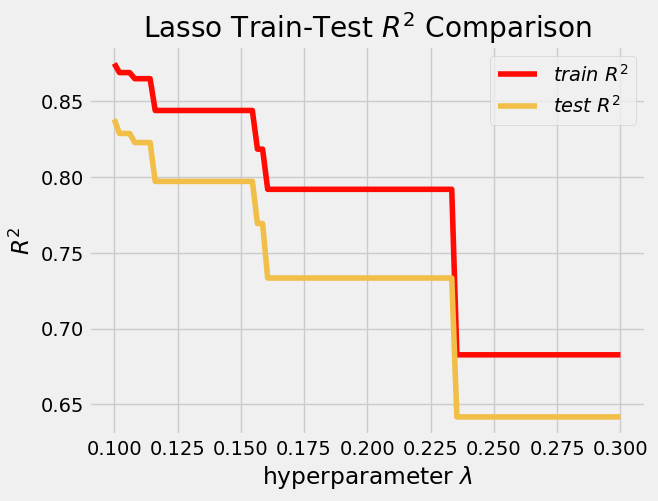

In [16]:
lasso_graph(0.1, 0.3, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

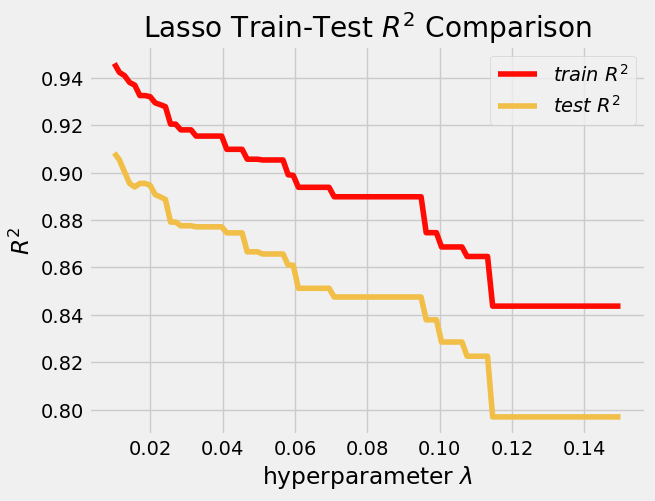

In [17]:
lasso_graph(0.01, 0.15, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

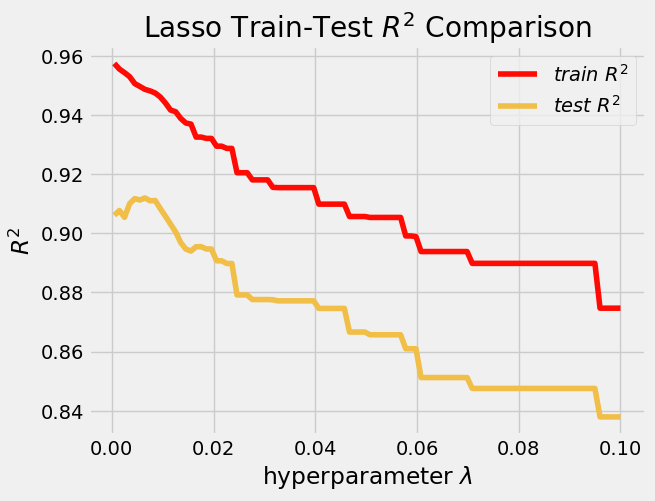

In [18]:
lasso_graph(0.0005, 0.1, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

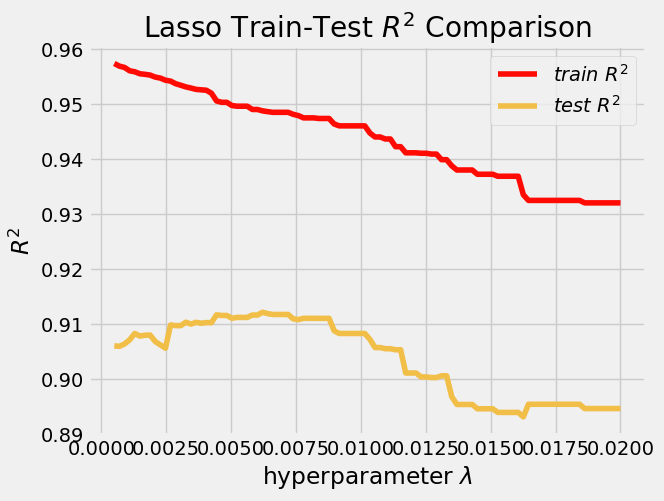

In [19]:
lasso_graph(0.0005, 0.02, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

In [20]:
train_score, test_score,feats_005= lasso_linear_model_score(
           train, 
           test,
           0.008576, 
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

In [21]:
len(feats_005)

47

In [22]:
test_score

0.9110498030205192

In [23]:
feats_005

['Cat__x0_160',
 'Cat__x0_30',
 'Cat__x1_C (all)',
 'Cat__x1_RM',
 'Cat__x8_ClearCr',
 'Cat__x8_Crawfor',
 'Cat__x8_Edwards',
 'Cat__x8_GrnHill',
 'Cat__x8_MeadowV',
 'Cat__x8_NridgHt',
 'Cat__x8_Somerst',
 'Cat__x8_StoneBr',
 'Cat__x9_Norm',
 'Cat__x11_1Fam',
 'Cat__x11_Twnhs',
 'Cat__x15_BrkFace',
 'Cat__x15_PreCast',
 'Cat__x18_PConc',
 'Cat__x22_N',
 'Cat__x24_Maj2',
 'Cat__x24_Typ',
 'Cat__x25_Attchd',
 'Cat__x29_Normal',
 'GrLivArea',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'HeatingQC',
 '1stFlrSF',
 'BsmtFullBath',
 'KitchenQual',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'PavedDrive',
 'ScreenPorch']

In [24]:
def tlasso_graph(alpha_start, alpha_stop, alpha_num,
               train, 
               test,
               target, 
               cat_feats,
               drop_cols = ['SalePrice', 'TotalBsmtSF']
               ):
    lasso_scores_train = []

    lasso_scores_test  = []

    alphas = np.linspace(alpha_start, alpha_stop, alpha_num)

    for alpha in alphas:
        try:
            train_score, test_score,lasso_feats = lasso_linear_model_score(
                train, 
               test,
               alpha, 
               target, 
               cat_feats,
               drop_cols
            )
            lasso_scores_train.append(train_score)
            lasso_scores_test.append(test_score)
        except ValueError:
            print(f'Alpha of {alpha} fails')
            lasso_scores_train.append(0)
            lasso_scores_test.append(0)

    lasso_scores_train = np.array(lasso_scores_train) 
    lasso_scores_test  = np.array(lasso_scores_test)
    #graph
    # construct df.
    lasso_alpha_scores = pd.DataFrame({"alphas":alphas,
                'train':lasso_scores_train,
                'test':lasso_scores_test})
    # change df to graphable structure.
    graph_df = pd.melt(
        lasso_alpha_scores,
        id_vars=['alphas'], 
        value_vars=['train','test']
    )
    graph_df.columns = ['alphas','data_type','model_score']

    sns.relplot(data = graph_df,
                x = 'alphas', y = 'model_score',hue = 'data_type',
                kind = 'line'
                )
    # define variable for test train model that is the closest.
    lasso_alpha_scores['train_test_dist'] = abs(lasso_alpha_scores['train'] -
                                                lasso_alpha_scores['test'])
    shortest_dist = lasso_alpha_scores.sort_values('train_test_dist'
                                               ).reset_index(drop = True).loc[0,:]
    best_lasso_alpha = shortest_dist['alphas']
    best_lasso_train = shortest_dist['train']
    best_lasso_test = shortest_dist['test']
    best_lasso_dist = shortest_dist['train_test_dist']

    # construct clostest alpha line
    plt.plot([best_lasso_alpha,best_lasso_alpha], 
             [best_lasso_train,best_lasso_test],color=colors[2])
    plt.plot(best_lasso_alpha, best_lasso_train,
             marker='o', markersize=8,
             color=colors[2])
    plt.plot(best_lasso_alpha, best_lasso_test,
             marker='o', markersize=8,
             color=colors[2])
    # label closest alpha point
    plt.text(best_lasso_alpha +.0005, ((best_lasso_test+best_lasso_train)/2), 
             "Alpha = {:.5f}\nDistance = {:.5f}".format(best_lasso_alpha,best_lasso_dist))
    
    # define variable for the test model that has the best score
    
    test_max = lasso_alpha_scores.sort_values('test',ascending=False
                                             ).reset_index(drop = True).loc[0,:]
    best_lasso_alpha = test_max['alphas']
    best_lasso_test = test_max['test']

    plt.plot(best_lasso_alpha, best_lasso_test,
             marker='o', markersize=8,
             color=colors[3])
    plt.text(best_lasso_alpha +.0005, best_lasso_test, 
         "Alpha = {:.5f}\nScore = {:.3f}".format(best_lasso_alpha,best_lasso_test))
    
    
    

    plt.title(r'Lasso Train-Test $R^2$ Comparison')
    plt.xlabel(r'hyperparameter $\lambda$')
    plt.ylabel(r'$R^2$')

    plt.show()

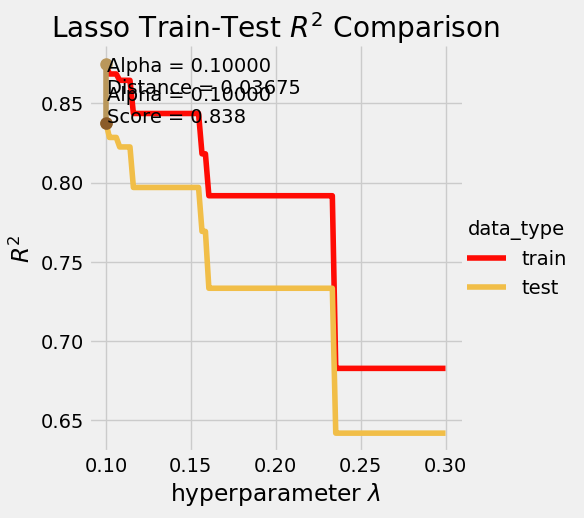

In [25]:
tlasso_graph(0.1, 0.3, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

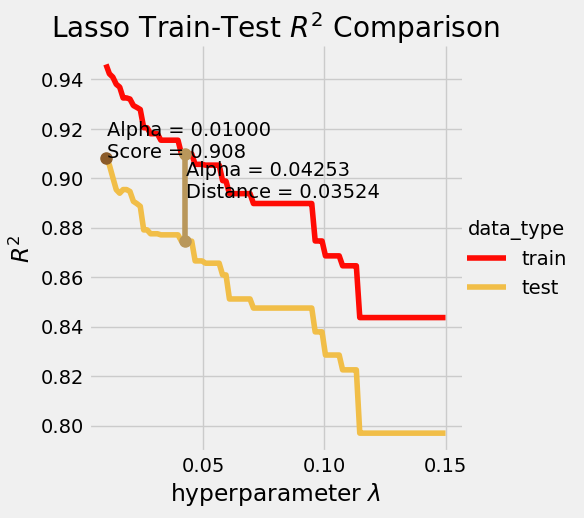

In [26]:
tlasso_graph(0.01, 0.15, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

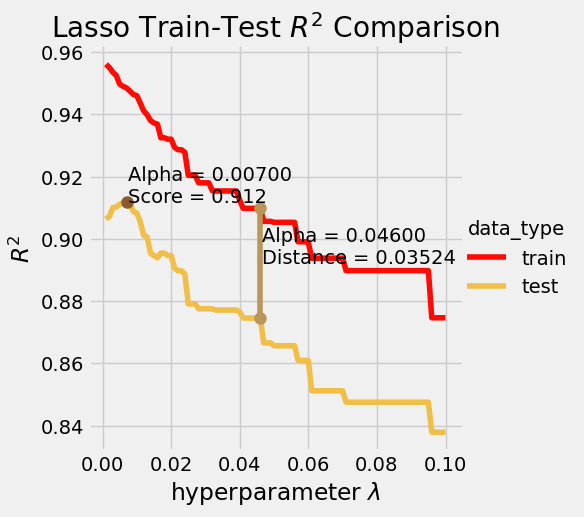

In [27]:
tlasso_graph(0.001, 0.1, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

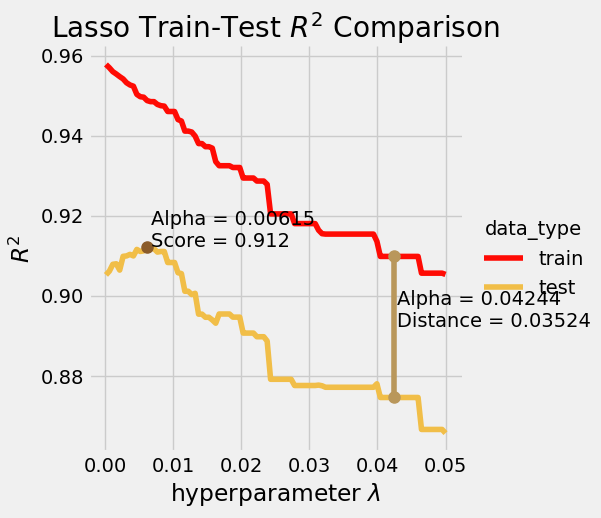

In [28]:
tlasso_graph(0.0001, 0.05, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

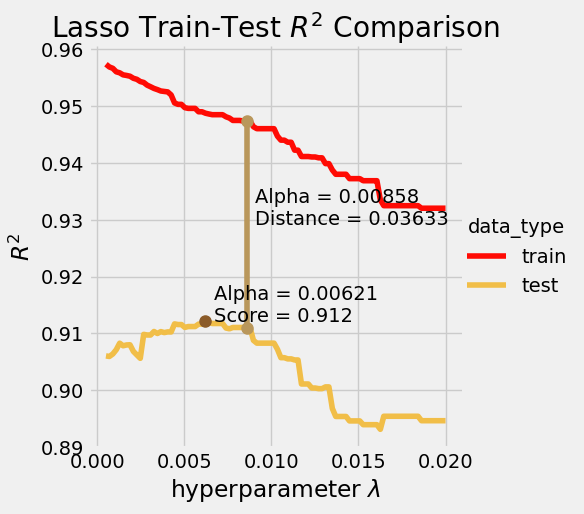

In [29]:
tlasso_graph(0.0005, 0.02, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

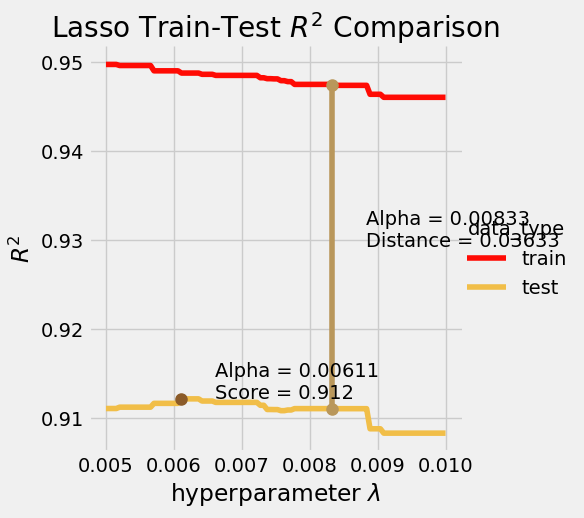

In [30]:
tlasso_graph(0.005, 0.01, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

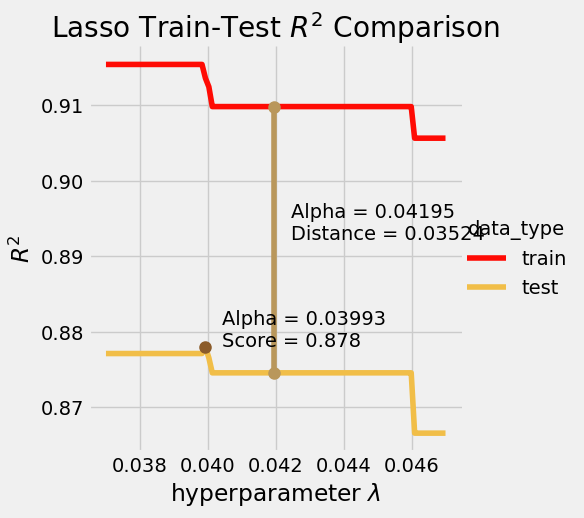

In [31]:
tlasso_graph(0.037, 0.047, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

In [32]:
train_score, test_score,feats_04195= lasso_linear_model_score(
           train, 
           test,
           0.04195, 
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

In [33]:
feats_04195

['Cat__x1_RM',
 'Cat__x22_N',
 'GrLivArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'ExterQual',
 'BsmtQual',
 'BsmtFinSF1',
 '1stFlrSF',
 'KitchenQual',
 'Fireplaces',
 'GarageFinish',
 'GarageCars',
 'GarageArea']

In [34]:
train_score, test_score,feats_00858= lasso_linear_model_score(
           train, 
           test,
           0.00858, 
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

In [35]:
feats_00858

['Cat__x0_160',
 'Cat__x0_30',
 'Cat__x1_C (all)',
 'Cat__x1_RM',
 'Cat__x8_ClearCr',
 'Cat__x8_Crawfor',
 'Cat__x8_Edwards',
 'Cat__x8_GrnHill',
 'Cat__x8_MeadowV',
 'Cat__x8_NridgHt',
 'Cat__x8_Somerst',
 'Cat__x8_StoneBr',
 'Cat__x9_Norm',
 'Cat__x11_1Fam',
 'Cat__x11_Twnhs',
 'Cat__x15_BrkFace',
 'Cat__x15_PreCast',
 'Cat__x18_PConc',
 'Cat__x22_N',
 'Cat__x24_Maj2',
 'Cat__x24_Typ',
 'Cat__x25_Attchd',
 'Cat__x29_Normal',
 'GrLivArea',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'HeatingQC',
 '1stFlrSF',
 'BsmtFullBath',
 'KitchenQual',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'PavedDrive',
 'ScreenPorch']

## YearBuilt Feature Engineering

I see that YearBuilt is kind of important. I could imagine that age of a house could have a non linear relationship. So i'm going to play around with doing nonlinear transformations and see if it makes any difference.

In [36]:
train['year_old'] = 2010 - train['YearBuilt']
test['year_old'] = 2010 - test['YearBuilt']

In [37]:
train['year_old2'] = train["year_old"] ** 2
train['year_old3'] = train["year_old"] ** 3
train['year_old_square'] = np.sqrt(train["year_old"])

test['year_old2'] = test["year_old"] ** 2
test['year_old3'] = test["year_old"] ** 3
test['year_old_square'] = np.sqrt(test["year_old"])

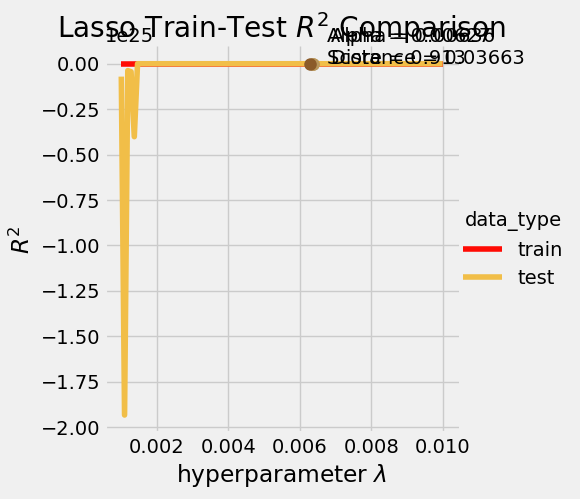

In [38]:
tlasso_graph(0.001, 0.01, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

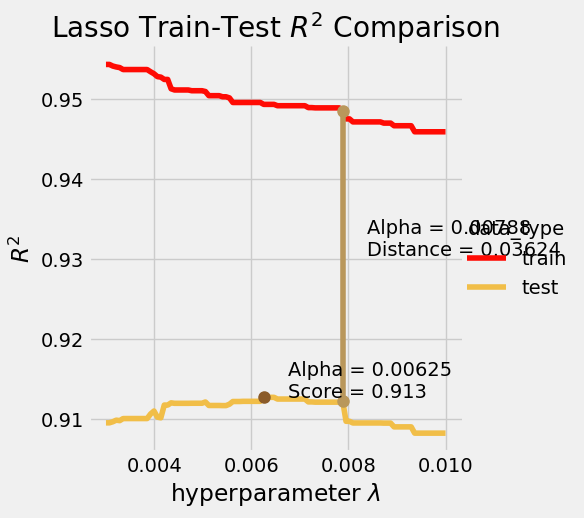

In [39]:
tlasso_graph(0.003, 0.01, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

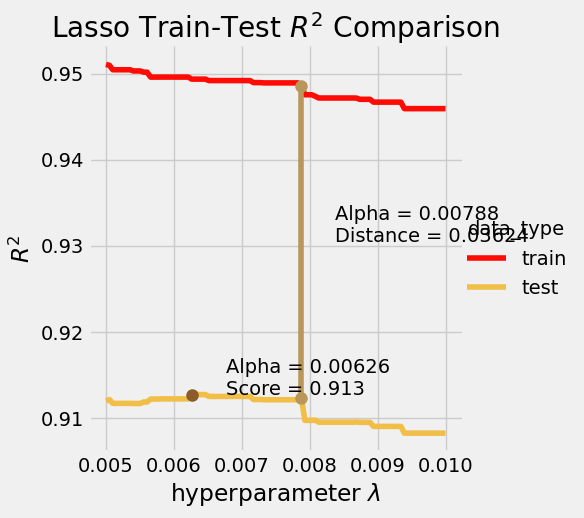

In [40]:
tlasso_graph(0.005, 0.01, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

The scores are the smallest amount different. And year_old_square is used as a feature over just year old. This makes sense to me. The old of the house matters less and less the older it is. If the house is 50 year olds vs 100 year old is the same distance between a newly built house and a 50 year old house. 

In [41]:
train_score, test_score,feats_00788= lasso_linear_model_score(
           train, 
           test,
           0.00788, 
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

In [42]:
feats_00788

['Cat__x0_160',
 'Cat__x0_30',
 'Cat__x1_C (all)',
 'Cat__x1_RM',
 'Cat__x3_Reg',
 'Cat__x8_ClearCr',
 'Cat__x8_Crawfor',
 'Cat__x8_Edwards',
 'Cat__x8_GrnHill',
 'Cat__x8_MeadowV',
 'Cat__x8_NoRidge',
 'Cat__x8_NridgHt',
 'Cat__x8_Somerst',
 'Cat__x8_StoneBr',
 'Cat__x9_Norm',
 'Cat__x11_1Fam',
 'Cat__x11_Twnhs',
 'Cat__x15_BrkFace',
 'Cat__x15_PreCast',
 'Cat__x18_PConc',
 'Cat__x22_N',
 'Cat__x24_Maj1',
 'Cat__x24_Maj2',
 'Cat__x24_Typ',
 'Cat__x25_Attchd',
 'Cat__x29_Normal',
 'GrLivArea',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'HeatingQC',
 '1stFlrSF',
 'BsmtFullBath',
 'KitchenAbvGr',
 'KitchenQual',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'PavedDrive',
 'WoodDeckSF',
 'ScreenPorch',
 'year_old_square']

In [43]:
train_score

0.9485466597386601

In [44]:
test_score

0.9123056381207566

In [45]:
len(feats_00788)

52

In [8]:
def lasso_only_graph(alpha_start, alpha_stop, alpha_num,
               train, 
               test,
               target, 
               cat_feats,
               drop_cols = ['SalePrice', 'TotalBsmtSF']
               ):
    lasso_scores_train = []

    lasso_scores_test  = []

    alphas = np.linspace(alpha_start, alpha_stop, alpha_num)

    for alpha in alphas:
        try:
            train_score, test_score,lasso_feats = lasso_model_score(
                train, 
               test,
               alpha, 
               target, 
               cat_feats,
               drop_cols
            )
            lasso_scores_train.append(train_score)
            lasso_scores_test.append(test_score)
        except ValueError:
            print(f'Alpha of {alpha} fails')
            lasso_scores_train.append(0)
            lasso_scores_test.append(0)

    lasso_scores_train = np.array(lasso_scores_train) 
    lasso_scores_test  = np.array(lasso_scores_test)
    #graph
    # construct df.
    lasso_alpha_scores = pd.DataFrame({"alphas":alphas,
                'train':lasso_scores_train,
                'test':lasso_scores_test})
    # change df to graphable structure.
    graph_df = pd.melt(
        lasso_alpha_scores,
        id_vars=['alphas'], 
        value_vars=['train','test']
    )
    graph_df.columns = ['alphas','data_type','model_score']

    sns.relplot(data = graph_df,
                x = 'alphas', y = 'model_score',hue = 'data_type',
                kind = 'line'
                )
    # define variable for test train model that is the closest.
    lasso_alpha_scores['train_test_dist'] = abs(lasso_alpha_scores['train'] -
                                                lasso_alpha_scores['test'])
    shortest_dist = lasso_alpha_scores.sort_values('train_test_dist'
                                               ).reset_index(drop = True).loc[0,:]
    best_lasso_alpha = shortest_dist['alphas']
    best_lasso_train = shortest_dist['train']
    best_lasso_test = shortest_dist['test']
    best_lasso_dist = shortest_dist['train_test_dist']

    # construct clostest alpha line
    plt.plot([best_lasso_alpha,best_lasso_alpha], 
             [best_lasso_train,best_lasso_test],color=colors[2])
    plt.plot(best_lasso_alpha, best_lasso_train,
             marker='o', markersize=8,
             color=colors[2])
    plt.plot(best_lasso_alpha, best_lasso_test,
             marker='o', markersize=8,
             color=colors[2])
    # label closest alpha point
    plt.text(best_lasso_alpha +.0005, ((best_lasso_test+best_lasso_train)/2), 
             "Alpha = {:.5f}\nDistance = {:.5f}".format(best_lasso_alpha,best_lasso_dist))
    
    # define variable for the test model that has the best score
    
    test_max = lasso_alpha_scores.sort_values('test',ascending=False
                                             ).reset_index(drop = True).loc[0,:]
    best_lasso_alpha = test_max['alphas']
    best_lasso_test = test_max['test']

    plt.plot(best_lasso_alpha, best_lasso_test,
             marker='o', markersize=8,
             color=colors[3])
    plt.text(best_lasso_alpha +.0005, best_lasso_test, 
         "Alpha = {:.5f}\nScore = {:.3f}".format(best_lasso_alpha,best_lasso_test))
    
    
    

    plt.title(r'Lasso Train-Test $R^2$ Comparison')
    plt.xlabel(r'hyperparameter $\lambda$')
    plt.ylabel(r'$R^2$')

    plt.show()

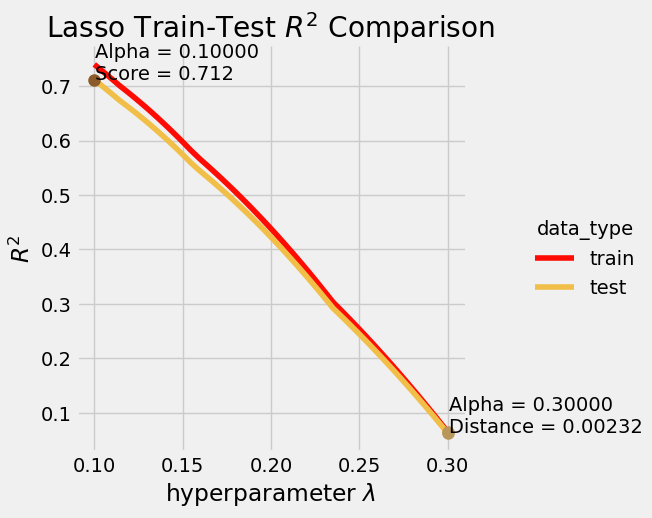

In [9]:
lasso_only_graph(0.1, 0.3, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

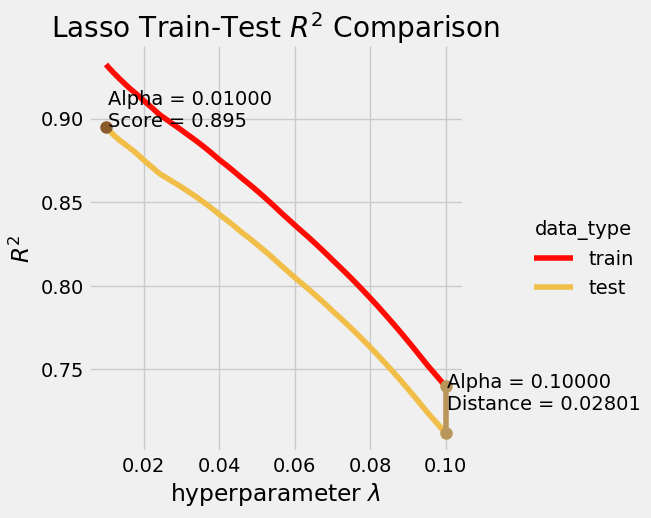

In [10]:
lasso_only_graph(0.01, 0.1, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

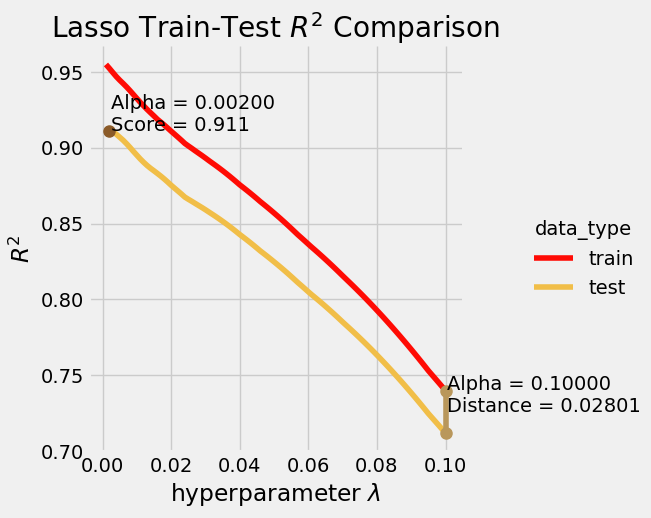

In [11]:
lasso_only_graph(0.001, 0.1, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

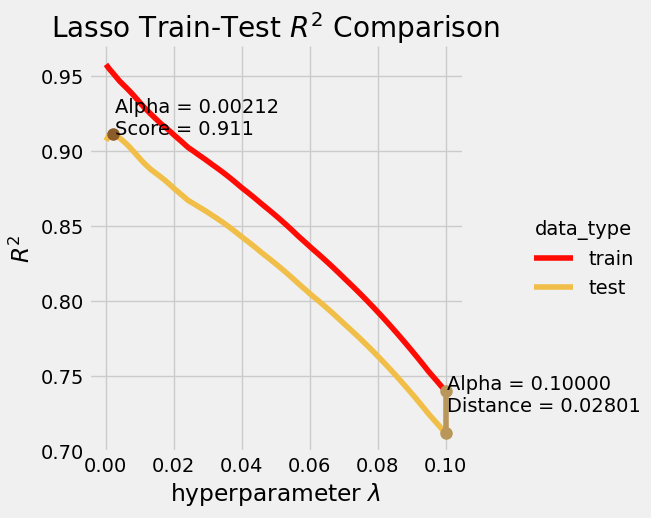

In [12]:
lasso_only_graph(0.0001, 0.1, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

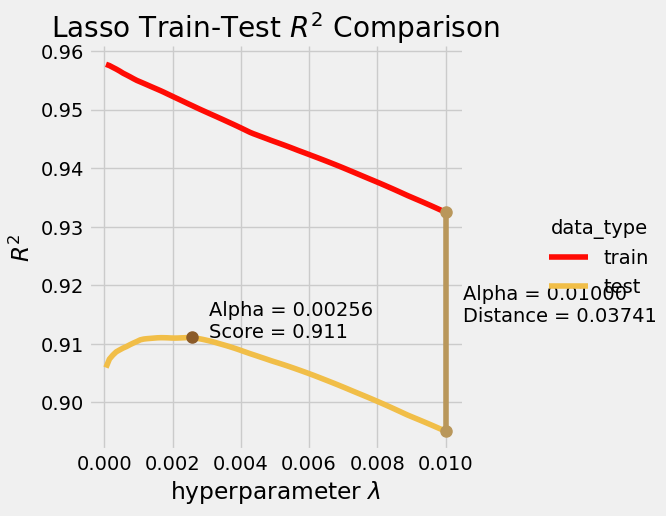

In [14]:
lasso_only_graph(0.00005, 0.01, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

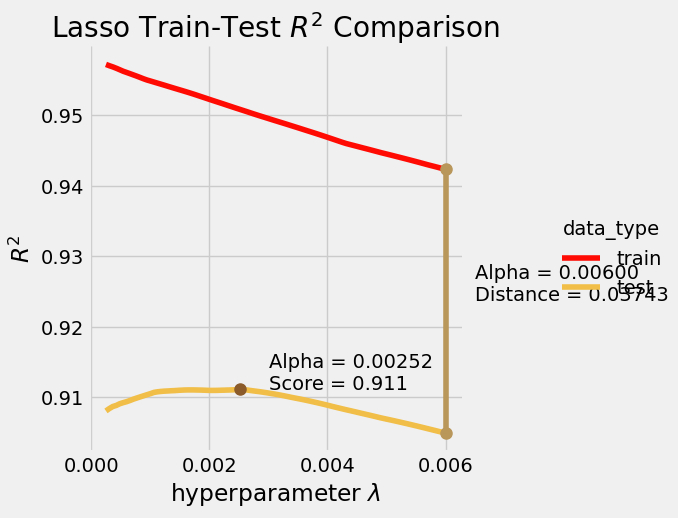

In [17]:
lasso_only_graph(0.00025, 0.006, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

In [21]:
train_score, test_score, lasso_feats = lasso_model_score(train, test, .00252, 'SalePrice', 
                             cat_feats,
                             drop_cols = ['SalePrice', 'TotalBsmtSF'])

In [22]:
lasso_feats

['Cat__x0_150',
 'Cat__x0_160',
 'Cat__x0_30',
 'Cat__x0_90',
 'Cat__x1_C (all)',
 'Cat__x1_RH',
 'Cat__x1_RL',
 'Cat__x1_RM',
 'Cat__x2_Grvl',
 'Cat__x3_IR2',
 'Cat__x4_Bnk',
 'Cat__x6_CulDSac',
 'Cat__x6_FR2',
 'Cat__x6_FR3',
 'Cat__x8_BrDale',
 'Cat__x8_BrkSide',
 'Cat__x8_ClearCr',
 'Cat__x8_CollgCr',
 'Cat__x8_Crawfor',
 'Cat__x8_Edwards',
 'Cat__x8_Greens',
 'Cat__x8_GrnHill',
 'Cat__x8_MeadowV',
 'Cat__x8_NoRidge',
 'Cat__x8_NridgHt',
 'Cat__x8_OldTown',
 'Cat__x8_SawyerW',
 'Cat__x8_Somerst',
 'Cat__x8_StoneBr',
 'Cat__x8_Veenker',
 'Cat__x9_Feedr',
 'Cat__x9_Norm',
 'Cat__x10_Feedr',
 'Cat__x10_PosN',
 'Cat__x11_1Fam',
 'Cat__x11_Twnhs',
 'Cat__x13_Flat',
 'Cat__x15_BrkComm',
 'Cat__x15_BrkFace',
 'Cat__x15_HdBoard',
 'Cat__x15_PreCast',
 'Cat__x16_AsbShng',
 'Cat__x16_CBlock',
 'Cat__x16_Plywood',
 'Cat__x16_VinylSd',
 'Cat__x16_Wd Shng',
 'Cat__x18_BrkTil',
 'Cat__x18_PConc',
 'Cat__x18_Wood',
 'Cat__x19_ALQ',
 'Cat__x19_GLQ',
 'Cat__x19_LwQ',
 'Cat__x19_Rec',
 'Cat__x19_Unf

In [23]:
len(lasso_feats)

102

In [74]:
def lasso_only_graph_len(alpha_start, alpha_stop, alpha_num,
               train, 
               test,
               target, 
               cat_feats,
               drop_cols = ['SalePrice', 'TotalBsmtSF']
               ):
    lasso_scores_train = []

    lasso_scores_test  = []
    lasso_feat_len = []

    alphas = np.linspace(alpha_start, alpha_stop, alpha_num)

    for alpha in alphas:
        try:
            train_score, test_score,lasso_feats = lasso_model_score(
                train, 
               test,
               alpha, 
               target, 
               cat_feats,
               drop_cols
            )
            lasso_scores_train.append(train_score)
            lasso_scores_test.append(test_score)
            lasso_feat_len.append(len(lasso_feats))
        except ValueError:
            print(f'Alpha of {alpha} fails')
            lasso_scores_train.append(0)
            lasso_scores_test.append(0)
            lasso_feat_len.append(0)

    lasso_scores_train = np.array(lasso_scores_train) 
    lasso_scores_test  = np.array(lasso_scores_test)
    lasso_feat_len = np.array(lasso_feat_len)
    #graph
    # construct df.
    lasso_alpha_scores = pd.DataFrame({"alphas":alphas,
                'train':lasso_scores_train,
                'test':lasso_scores_test,
                'feature_len':lasso_feat_len,                                       
                                      })
    # change df to graphable structure.
    graph_df = pd.melt(
        lasso_alpha_scores,
        id_vars=['alphas'], 
        value_vars=['train','test']
    )
    graph_df.columns = ['alphas','data_type','model_score']
    
    fig, axs = plt.subplots(2,1,figsize=(10,12))
    sns.lineplot(data = graph_df,
                x = 'alphas', y = 'model_score',hue = 'data_type',
                ax=axs[0]
                )
    # define variable for test train model that is the closest.
    lasso_alpha_scores['train_test_dist'] = abs(lasso_alpha_scores['train'] -
                                                lasso_alpha_scores['test'])
    shortest_dist = lasso_alpha_scores.sort_values('train_test_dist'
                                               ).reset_index(drop = True).loc[0,:]
    best_lasso_alpha = shortest_dist['alphas']
    best_lasso_train = shortest_dist['train']
    best_lasso_test = shortest_dist['test']
    best_lasso_dist = shortest_dist['train_test_dist']

    # construct clostest alpha line
    axs[0].plot([best_lasso_alpha,best_lasso_alpha], 
             [best_lasso_train,best_lasso_test],color=colors[2])
    axs[0].plot(best_lasso_alpha, best_lasso_train,
             marker='o', markersize=8,
             color=colors[2])
    axs[0].plot(best_lasso_alpha, best_lasso_test,
             marker='o', markersize=8,
             color=colors[2])
    # label closest alpha point
    axs[0].text(best_lasso_alpha +.0005, ((best_lasso_test+best_lasso_train)/2), 
             "Alpha = {:.5f}\nDistance = {:.5f}".format(best_lasso_alpha,best_lasso_dist))
    
    # define variable for the test model that has the best score
    
    test_max = lasso_alpha_scores.sort_values('test',ascending=False
                                             ).reset_index(drop = True).loc[0,:]
    best_lasso_alpha = test_max['alphas']
    best_lasso_test = test_max['test']

    axs[0].plot(best_lasso_alpha, best_lasso_test,
             marker='o', markersize=8,
             color=colors[3])
    axs[0].text(best_lasso_alpha +.0005, best_lasso_test, 
         "Alpha = {:.5f}\nScore = {:.3f}".format(best_lasso_alpha,best_lasso_test))
    
    
    

    axs[0].set_title(r'Lasso Train-Test $R^2$ Comparison')
    axs[0].set_xlabel(r'hyperparameter $\alpha$')
    axs[0].set_ylabel(r'$R^2$')
    
    axs[1].set_xlabel(r'hyperparameter $\alpha$')
    axs[1].set_ylabel(r'Number of Features')




    
    sns.lineplot(data = lasso_alpha_scores,
            x = 'alphas', y = 'feature_len',
                 color = colors[2],
            ax=axs[1]
            )
    plt.show()

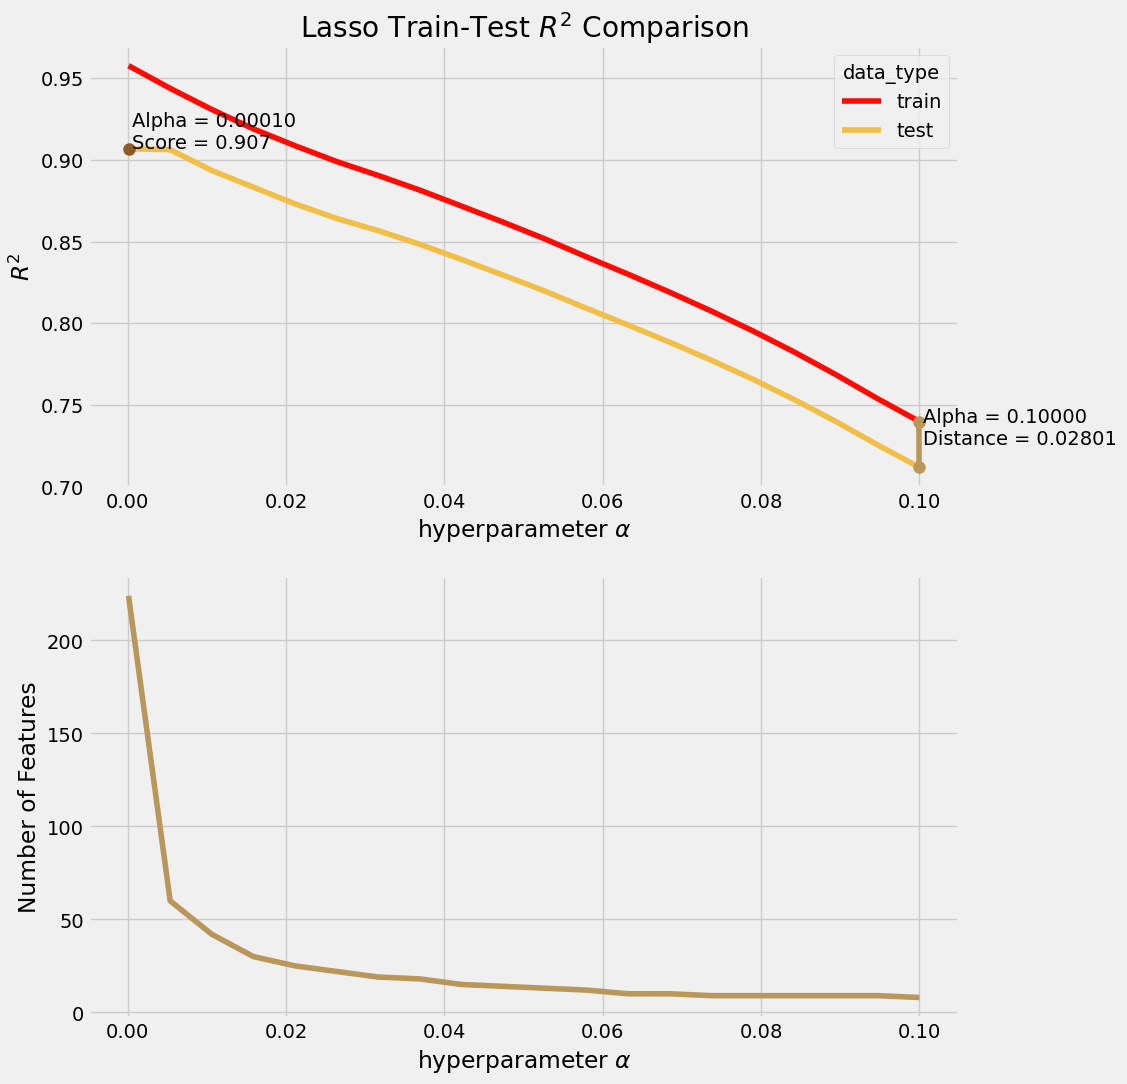

In [75]:
lasso_only_graph_len(0.0001, 0.1, 20,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

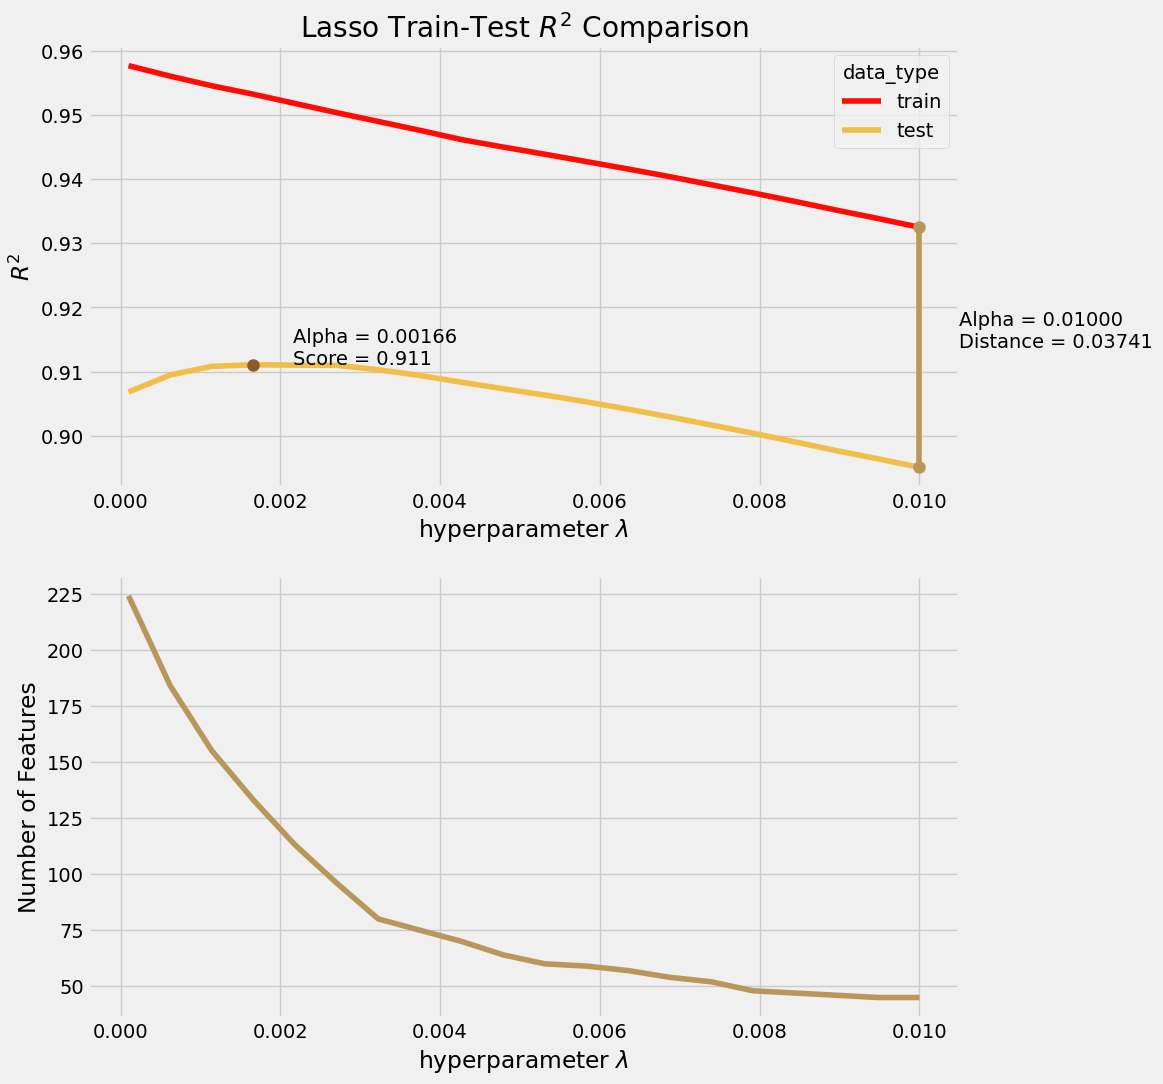

In [59]:
lasso_only_graph_len(0.0001, 0.01, 20,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

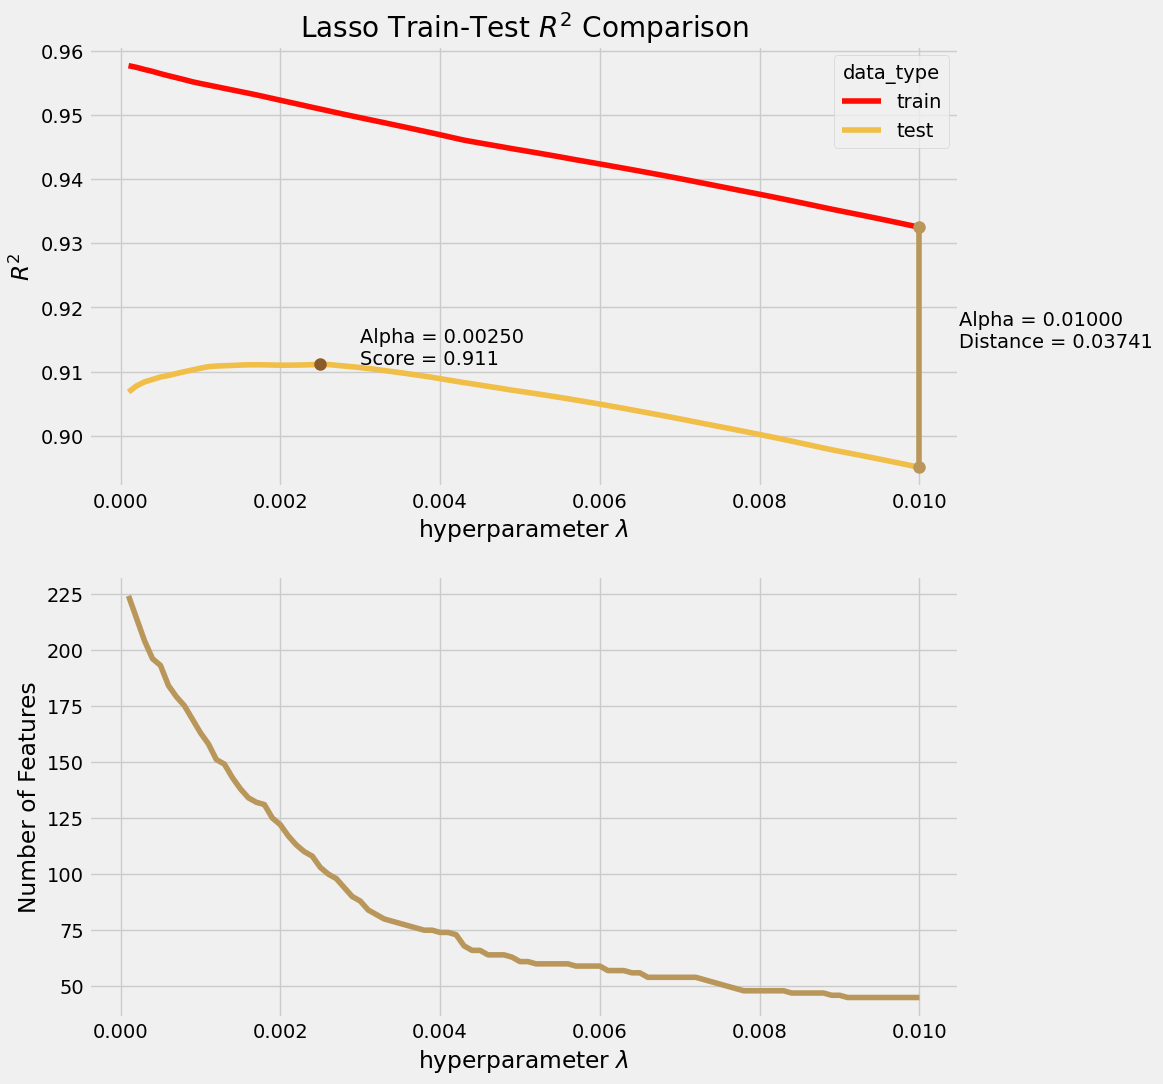

In [60]:
lasso_only_graph_len(0.0001, 0.01, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

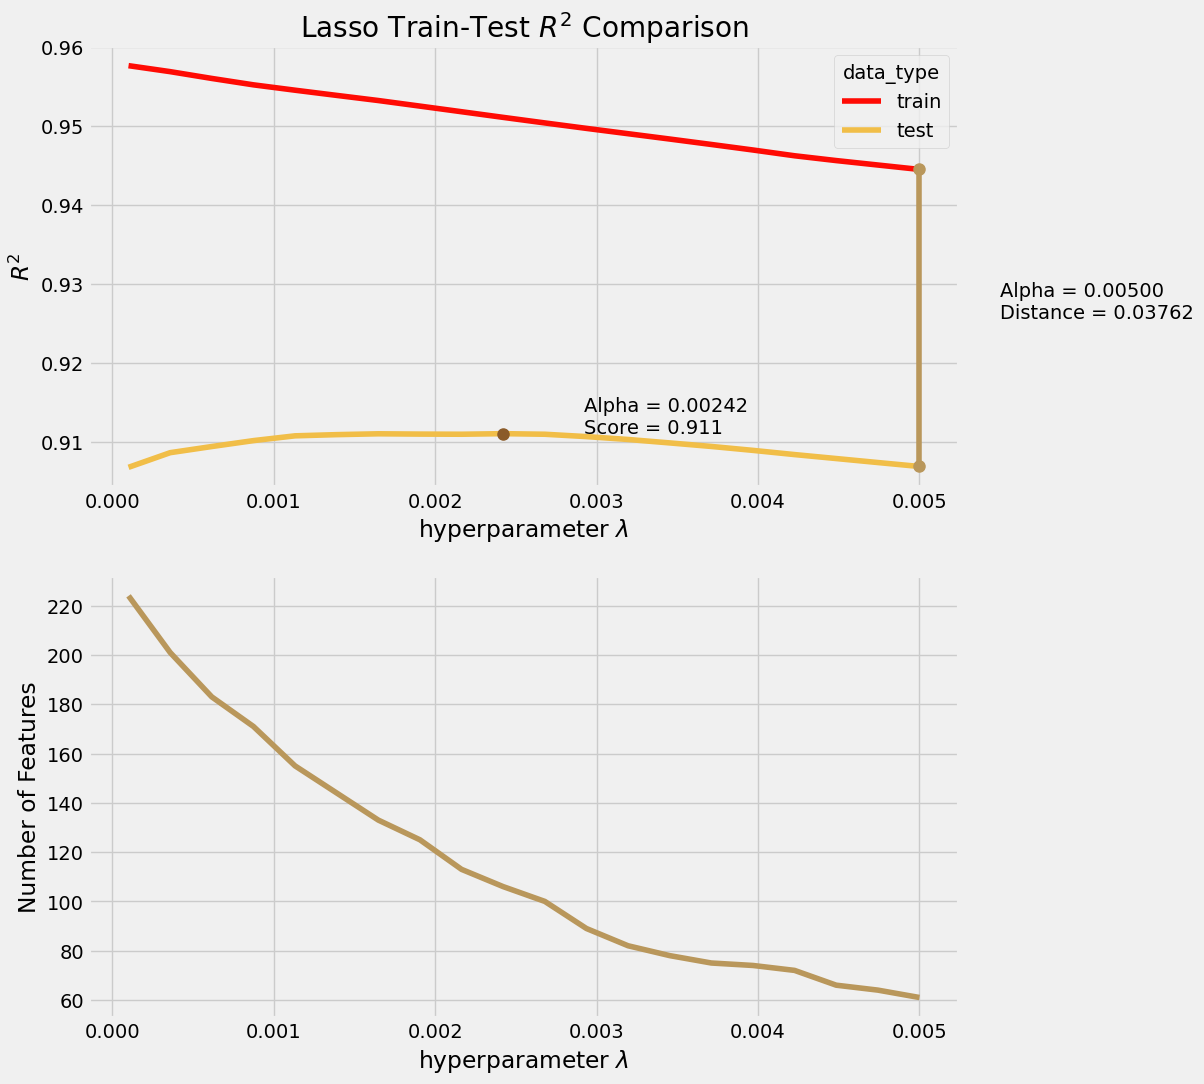

In [61]:
lasso_only_graph_len(0.0001, 0.005, 20,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

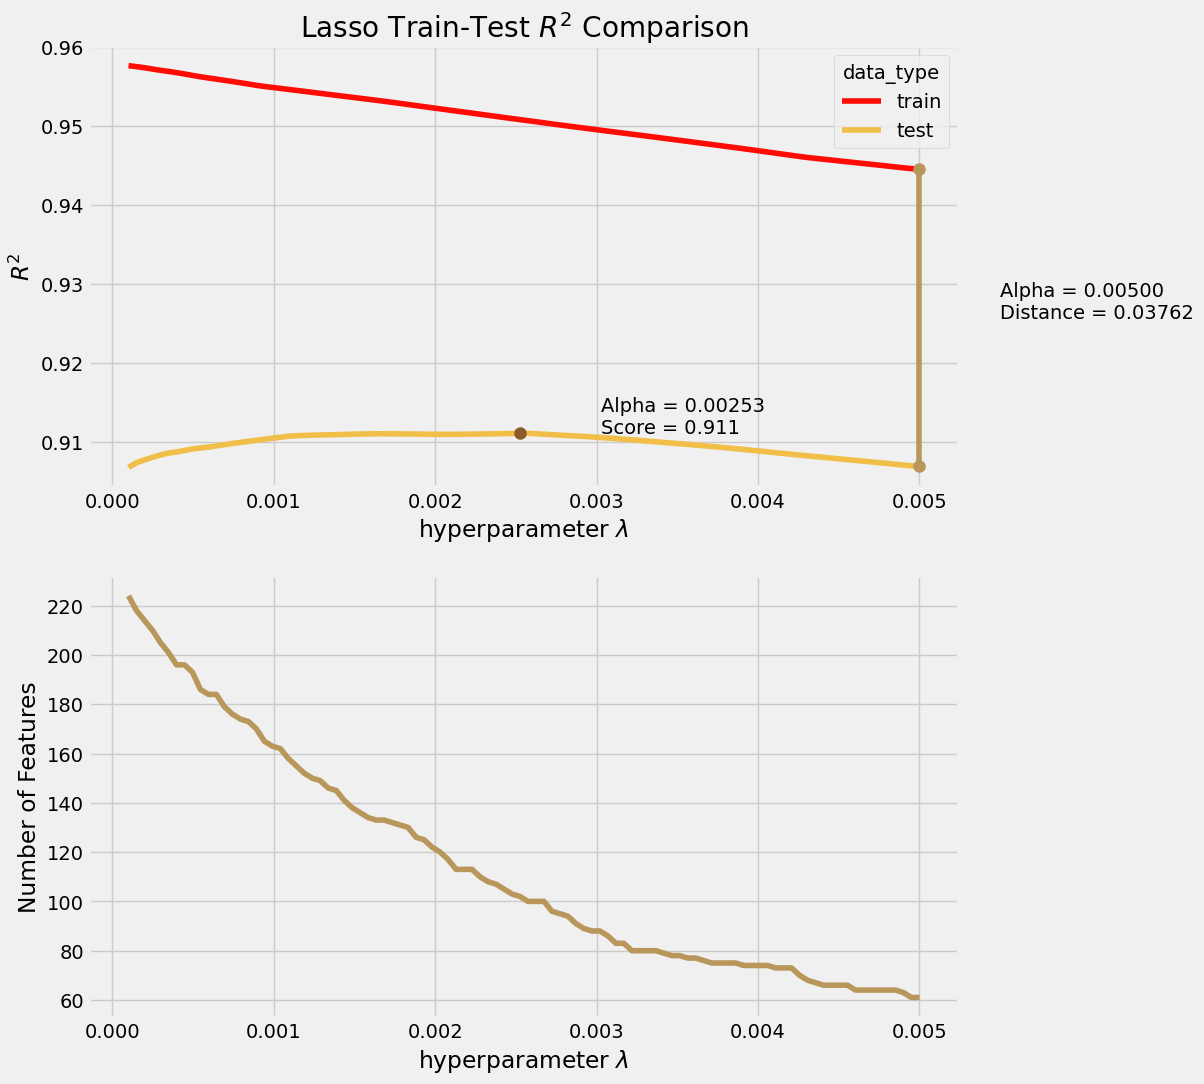

In [62]:
lasso_only_graph_len(0.0001, 0.005, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

In [70]:
train_score00253, test_score00253,lasso_feats00253 = lasso_model_score(
                train, 
           test,
    .00253,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

In [71]:
train_score005, test_score005,lasso_feats005 = lasso_model_score(
                train, 
           test,
    .005,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

In [72]:
print(len(lasso_feats00253))
lasso_feats00253

102


['Cat__x0_150',
 'Cat__x0_160',
 'Cat__x0_30',
 'Cat__x0_90',
 'Cat__x1_C (all)',
 'Cat__x1_RH',
 'Cat__x1_RL',
 'Cat__x1_RM',
 'Cat__x2_Grvl',
 'Cat__x3_IR2',
 'Cat__x4_Bnk',
 'Cat__x6_CulDSac',
 'Cat__x6_FR2',
 'Cat__x6_FR3',
 'Cat__x8_BrDale',
 'Cat__x8_BrkSide',
 'Cat__x8_ClearCr',
 'Cat__x8_CollgCr',
 'Cat__x8_Crawfor',
 'Cat__x8_Edwards',
 'Cat__x8_Greens',
 'Cat__x8_GrnHill',
 'Cat__x8_MeadowV',
 'Cat__x8_NoRidge',
 'Cat__x8_NridgHt',
 'Cat__x8_OldTown',
 'Cat__x8_SawyerW',
 'Cat__x8_Somerst',
 'Cat__x8_StoneBr',
 'Cat__x8_Veenker',
 'Cat__x9_Feedr',
 'Cat__x9_Norm',
 'Cat__x10_Feedr',
 'Cat__x10_PosN',
 'Cat__x11_1Fam',
 'Cat__x11_Twnhs',
 'Cat__x13_Flat',
 'Cat__x15_BrkComm',
 'Cat__x15_BrkFace',
 'Cat__x15_HdBoard',
 'Cat__x15_PreCast',
 'Cat__x16_AsbShng',
 'Cat__x16_CBlock',
 'Cat__x16_Plywood',
 'Cat__x16_VinylSd',
 'Cat__x16_Wd Shng',
 'Cat__x18_BrkTil',
 'Cat__x18_PConc',
 'Cat__x18_Wood',
 'Cat__x19_ALQ',
 'Cat__x19_GLQ',
 'Cat__x19_LwQ',
 'Cat__x19_Rec',
 'Cat__x19_Unf

In [73]:
print(len(lasso_feats005))
lasso_feats005

61


['Cat__x0_160',
 'Cat__x0_30',
 'Cat__x1_C (all)',
 'Cat__x1_RH',
 'Cat__x1_RM',
 'Cat__x6_CulDSac',
 'Cat__x8_ClearCr',
 'Cat__x8_Crawfor',
 'Cat__x8_Edwards',
 'Cat__x8_GrnHill',
 'Cat__x8_MeadowV',
 'Cat__x8_NoRidge',
 'Cat__x8_NridgHt',
 'Cat__x8_SawyerW',
 'Cat__x8_Somerst',
 'Cat__x8_StoneBr',
 'Cat__x9_Feedr',
 'Cat__x9_Norm',
 'Cat__x11_1Fam',
 'Cat__x11_Twnhs',
 'Cat__x13_Flat',
 'Cat__x15_BrkFace',
 'Cat__x15_PreCast',
 'Cat__x16_AsbShng',
 'Cat__x18_BrkTil',
 'Cat__x18_PConc',
 'Cat__x20_GLQ',
 'Cat__x22_N',
 'Cat__x24_Maj1',
 'Cat__x24_Maj2',
 'Cat__x24_Typ',
 'Cat__x25_Attchd',
 'Cat__x25_Basment',
 'Cat__x29_Normal',
 'GrLivArea',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'HeatingQC',
 '1stFlrSF',
 'BsmtFullBath',
 'KitchenAbvGr',
 'KitchenQual',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'PavedDrive